# BLM calculator

Steps in this pipeline:
1. Run the same scenario 6 times, 10 runs each, modifying the BLM value according to: 
BLM = Z*sqrt(PU area)
(Z = 0.001, 0.01, 0.1,1, 10 and 100)  
(Helper functions to run Marxan are at the bottom)

2. Spatial plot the best solution of each of these scenario outputs (Visually inspect changes in BLM)
3. Plot Boundary Length vs Cost (Curve)
4. Calculate the optimum BLM value that minimizes both cost and Boundary length (clumping)

*The planning units grid shapefile is requiered for the Boundary length calculation

## 1. Estimate BLM testing values (6 scenarios keeping all inputs equal except BLM)

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

In [8]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_Targets'
MARXAN_EXECUTABLE = f'{MARXAN_FOLDER}/MarOpt_v243_Linux64'
MARXAN_INPUTDATA = 'input.dat'

In [10]:
### PU Area
pu_area = gpd.read_file(f'{MARXAN_FOLDER}/pu/pulayer.shp')
#pu_area.crs

In [70]:
# BLM values to start calibration
# Rule of thumb: Z = pu_area*[0.01,0.1,1,10,100]
blm_range= [0.001,0.01,0.1,1,10,100]
area = pu_area['geometry'].map(lambda p: p.area / 10**6).mean()
blm_values = [element * math.sqrt(area) for element in blm_range]
blm_dict = dict(zip(blm_range, blm_values))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

## 2. Run Marxan 6 times with those BLM values

In [78]:
### RUN MARXAN 6 times
blm_folder=[]
for blm in blm_values:
    InputFile = DatFile(f'{MARXAN_FOLDER}/{MARXAN_INPUTDATA}')
    InputFile.read()
    userInputFile = inputDatFile.from_dat(InputFile.data)
    
    ## Modify for BLM calculations and save as new input.dat
    userInputFile.BLM = blm
    userInputFile.OUTPUTDIR =f'BLM_{blm}'
    userInputFile.NUMREPS =10
    
    userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
    userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
    userInputFile_df= userInputFile_df.drop('BLOCKDEFNAME')

    CreateFileFromDF(f'{MARXAN_FOLDER}/{MARXAN_INPUTDATA}',userInputFile_df,inputDatFile)
    
    os.mkdir(f'{MARXAN_FOLDER}/{userInputFile.OUTPUTDIR}')
    blm_folder.append(f'{userInputFile.OUTPUTDIR}')
    
    #EXECUTES MARXAN
    # Needs to execute marxan from the marxan root folder in order to make the file find the required data.
    os.chdir(MARXAN_FOLDER)
    with subprocess.Popen([MARXAN_EXECUTABLE],
                             stdout=subprocess.PIPE,
                             stderr=subprocess.STDOUT,
                             universal_newlines=True,
                          bufsize=-1) as process:
        while process.poll() is None:
            output = process.stdout.readline()
            if output:
                print(output.strip())

    os.chdir('/home/jovyan/work/notebooks/Lab')

Marxan v 2.43

Marine Reserve Design via Annealing

Coded by Ian Ball, modified by Matthew Watts
Written by Ian Ball and Hugh Possingham

ian.ball@aad.gov.au
h.possingham@uq.edu.au
m.watts@uq.edu.au

Marxan website

http://www.uq.edu.au/marxan

WARNING variable: CLUMPTYPE appears more than once in the input file. Final value taken

Entering in the data files
There are 12178 Planning units.
12178 Planning Unit names read in
59 species read in
25108 connections entered
36859 conservation values counted, 718502 big matrix size, 5.12998% density of matrix
Time passed so far is 0 secs

Pre-processing Section.

Run 1   Using Calculated Tinit = 1616.0000 Tcool = 0.99937063
Creating the initial reserve

Init:Value 3558010.7 Cost 3505544.0 PUs 6168 Connection 25912000.0 Missing 2 Shortfall 193000.00 Penalty 642.7 MPM 0.7

ThermalAnnealing:Value 1360110.0 Cost 1330604.0 PUs 3196 Connection 14348000.0 Missing 0 Shortfall 2220000.00 Penalty 810.0 MPM 1.0

Iterative Improvement:Value 1360110.0 Cost

## 3. Create a plot from the best solution of each BLM scenario

In [56]:
blm_folder

['BLM_0.002', 'BLM_0.02', 'BLM_0.2', 'BLM_2.0', 'BLM_20.0', 'BLM_200.0']

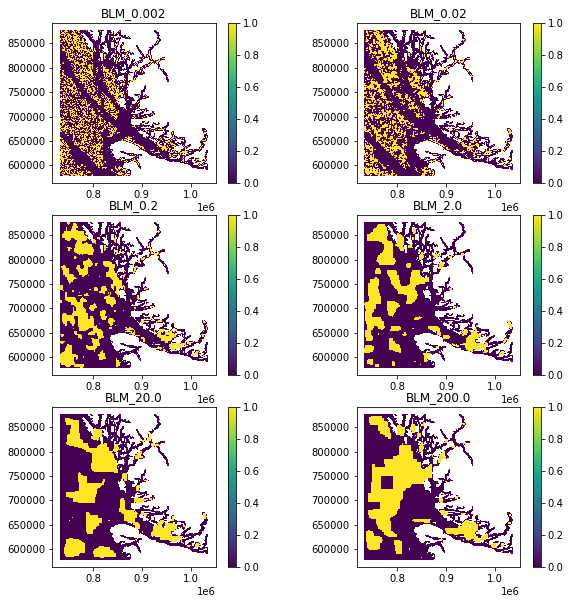

In [60]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig = plt.figure(figsize=(10,10))

for idx, blm in enumerate(blm_folder):
    axn = fig.add_subplot(321+idx)
    solution = pd.read_csv(f"{MARXAN_FOLDER}/{blm}/output_best.csv")
    solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'PUID',how='inner')
    solution_grid.plot(ax=axn,column='SOLUTION', legend=True)
    axn.set_title(f'{blm}')

## 4. Calculate optimum BLM

- For each BLM scenario infer best solution from lowest score  
- For each BLM scenario calculate Boundary Length of the best solution
- Create df with values for best solution of each BLM scenario 
- Find the point of max curvature to establish as optimum BLM with [kneed](https://www.kaggle.com/kevinarvai/knee-elbow-point-detection) package

In [92]:
import kneed
import matplotlib.pyplot as plt

def BLM_calibration(MARXAN_FOLDER, Plot=True):
    blm_df =pd.DataFrame(columns=['folder','blm'])
    blm_df['folder']= blm_folder
    blm_df['blm']= blm_values

    for blm in blm_folder:
        summary = pd.read_csv(f"{MARXAN_FOLDER}/{blm}/output_sum.csv")
        best =summary.loc[summary.loc[:]['Score'].idxmin(),'Run_Number']
        cost=summary.loc[best-1,'Cost']
        blm_df.loc[blm_df['folder']==blm,'cost']=cost
    
        solution = pd.read_csv(f"{MARXAN_FOLDER}/{blm}/output_best.csv")
        solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'PUID',how='inner')
        blm_df.loc[blm_df['folder']==blm,'boundary_length']=solution_grid.dissolve(by='SOLUTION')['geometry'].length[1] ## perimeter in m
    
    y = blm_df['boundary_length']
    x = blm_df['cost']
    kn = kneed.KneeLocator(x, y, curve='convex', direction='decreasing')
    best_blm = blm_df.loc[blm_df['cost']==kn.knee,'blm'].values[0]
    #blm_df.loc[blm_df['cost']==kn.knee,'folder'].values[0] #in which folder

    print(f'The optimun BLM is {best_blm}')
    
    
    if Plot==True:
        plt.xlabel('cost')
        plt.ylabel('boundary length')
        plt.plot(x, y, 'bx-')
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        
    return best_blm

The optimun BLM is 0.2


0.2

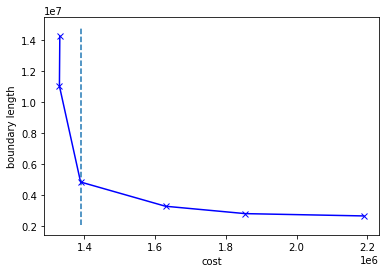

In [93]:
BLM_calibration(MARXAN_FOLDER)

### Helper functions to run Marxan

In [1]:
import subprocess
import os
import io
import re
import csv
from shutil import rmtree

from datetime import datetime
import abc
import collections
from typing import Generic, TypeVar, Generic, Optional, List, Type
from pydantic import BaseModel, ValidationError, validator, Field
from pydantic.generics import GenericModel


import pandas as pd
import geopandas as gpd
import qgrid
from IPython.display import display, JSON
import ipywidgets as widgets

import json

from uuid import UUID, uuid4

In [2]:
class DatFile(object):
    """
    Read and write dat files.
    """
    def __init__(self, file_path: str = None):
        # Ensure the file has the right extension
        if file_path and not file_path.endswith('.dat'):
            raise NameError("File must be a '.dat' extension")
        
        self.__path = file_path
        self.data = None
        
    def __test_path(self, path):
        if not self.__path and path:
            self.__path = path
        elif not self.__path and not path:
            raise NameError('No path to file provided')
    
    def update(self, data, incremental: bool = False ):
        """Updates the data.
    
        Args:
            data (any): The data the object should store.
        Returns:
            The contents of the file as a unicode string.
        """
        __conversion: dict = {
                                int: int,
                                str: str,
                                dict: dict,
                                list: list
                            }
        if not incremental or not self.data:
            self.data = data
        elif type(self.data) == dict:
            self.data.append(data)
        else:
            self.data = self.data + __conversion[type(self.data)](data)
        
    
    def read(self, file_path: str = None):
        """Gets a files contents as a unicode string.
    
        Args:
            filename (string): The full path to the file that will be read.
        Returns:
            The contents of the file as a unicode string.
        """
        self.__test_path(file_path)
        try:
            with io.open(self.__path, mode="r", encoding="utf-8") as f:
                self.data = f.readlines()
        except (UnicodeDecodeError) as e:
            with io.open(self.__path, mode="r", encoding="ISO-8859-1") as f:
                self.data = f.read()
        except Exception as e:
            raise e
    
    def write(self, file_path: str = None):
        """Writes a files contents as a unicode string
    
        Args:
            filename (string): The full path to the file that will be written.  
            s (string): The unicode string to write.  
            mode (string): Optional. The file write mode. Default value is w.  
        Returns:
            None  
        """
        self.__test_path(file_path)
        try:
            with io.open(self.__path, mode, encoding="utf-8") as f: 
                f.write(self.data)
        except Exception as e:
            raise e

In [3]:
# Just in case we need to format the float numbers in a very specific way
class MyNumber:
    """
    Number formater wraper to allow a specific format string for a float number.
    """
    def __init__(self, val):
        self.val = val

    def __format__(self,format_spec):
        ss = ('{0:'+format_spec+'}').format(self.val)
        if ( 'E' in ss):
            mantissa, exp = ss.split('E')            
            return mantissa + 'E'+ exp[0] + '00' + exp[1:]
        return ss

def num(s):
    """
    Coerce Number transformation into float.
    """
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s

def getSizeOfNestedList(listOfElem):
    ''' Get number of elements in a nested list'''
    count = 0
    # Iterate over the list
    for elem in listOfElem:
        # Check if type of element is list
        if type(elem) == list:  
            # Again call this function to get the size of this element
            count += getSizeOfNestedList(elem)
        else:
            count += 1    
    return count

def _readTabularFile(filename: str)-> dict:
    """
    Gets a input.dat file and outputs a dict of parameters.

    Args:
        filename (string): The full path to the file that will be read.
    Returns:
        The contents of the file as a dict.
    """
    inputData = DatFile(filename)
    inputData.read()
    outputData = []
    
    dialect= csv.Sniffer().sniff(inputData.data[0],[',', '\t',' '])
    for line in inputData.data: 
        if dialect.delimiter ==',':
            pair= re.compile('\s').split(line.replace('"','').replace(' ', '_').strip('""').strip('\r').strip('\n').replace(',', '\t'))
        else:
            pair= re.compile('\s').split(line.replace('"','').strip('""').strip('\r').strip('\n'))
        outputData.append(pair)
    return outputData


def CreateListModelFromFile(filename: str, model: Type['Model'])-> List['Model']:
    """
    Gets a input.dat file and outputs a list of selected model.

    Args:
        filename (string): The full path to the file that will be read.
        model (Type['Model']): Data model used to read and validate the data
    Returns:
        The contents of the file as a Data model list.
    """
    inputData = _readTabularFile(filename)
    return [model.parse_obj(dict(zip(inputData[0], x))) for x in inputData[1:]] 

def CreateFileFromDF(filename: str, df: Type['Dataframe'], model: Type['Model'])-> List[list]:
    """
    Gets a dataframe and outs a dat.file.

    Args:
        filename (string): The full path to the file that will be read.
        df (Type['Dataframe']): Dataframe to save
        model (Type['Model']): Data model used to read and validate the data
    Returns:
        The contents of the file as a Data model list.
    """
    if model == inputDatFile:
        data = df.transpose().to_dict('records')
        validatedData = [inputDatFile(**x) for x in data]
        keys = data[0].keys()
        csv.register_dialect('dat', delimiter=' ')
        with open(filename, 'w', encoding='utf8', newline='')  as output_file:
            dict_writer = csv.writer(output_file, dialect='dat')
            for row in data[0].items():
                dict_writer.writerow(row)
    else:
        data = df.to_dict('records')
        validatedData = [model(**x) for x in data]
#         keys = validatedData[0].__dict__.keys()
#         csv.register_dialect('dat', delimiter='\t')
#         with open(filename, 'w', encoding='utf8', newline='')  as output_file:
#             dict_writer = csv.DictWriter(output_file, keys, dialect='dat')
#             dict_writer.writeheader()
#         dict_writer.writerows(toCSV)
#             dict_writer.writerows(data)
    
        keys={k: v for k, v in data[0].items() if v is not None}.keys()
        dataNotNone = list(({key : val for key, val in sub.items() if val!= None} for sub in data)) 

        csv.register_dialect('dat', delimiter=' ')
        with open(filename, 'w', encoding='utf8', newline='')  as output_file:
            dict_writer = csv.DictWriter(output_file, keys, dialect='dat')
            dict_writer.writeheader()
            dict_writer.writerows(dataNotNone)
    
    
    return validatedData

def save_button(filename: str, model: Type['Model'], data: Type['QgridWidget'])-> None:
    """
    creates a widget button and attach a on click event.
    
    Args:
        filename (string): The full path to the file that will be read.
        data (Type['QgridWidget']): Qgrid widget
        model (Type['Model']): Data model used to read and validate the data
    """
    button = widgets.Button(description="Save")
    output = widgets.Output()

    display(button, output)

    def on_button_clicked(b):
        with output:
            CreateFileFromDF(filename, data.get_changed_df(), model)

    button.on_click(on_button_clicked)

In [77]:
class inputDatFile(BaseModel):
    """
    This is the description of the input data clase base on marxan input file.
    """
    
    # General Parameters
    VERSION: str = Field('0.1', title='Version', 
                         description='Type of input file')
    BLM:  Optional[float] = Field(0., title='Boundary Length Modifier', 
                           description='Boundary Length Modifier')
    PROP: float = Field(0., title='Starting Proportion', 
                            description='Proportion of planning units in initial reserve system')
    RANDSEED: Optional[int] = Field(-1, title='Random Seed', 
                              description='Random seed number')
    NUMREPS: int = Field(1, title='Repeat Runs', 
                             description='The number of repeat runs you wish to do')
    BESTSCORE: Optional[int] = Field(0, title='Best Score Speedup', 
                               description='This variable tells Marxan not to keep track of the best score \
                                until it reaches a specified minimum level.')
    
    # Annealing Parameters
    NUMITNS: int = Field(0, title='Number of Iterations', 
                         description='Number of iterations for annealing')
    STARTTEMP: int = Field(1, title='Initial Temperature', 
                           description='Starting temperature for annealing')
    COOLFAC: int = Field(0, title='Cooling Factor', 
                         description='Cooling factor for annealing')
    NUMTEMP: int = Field(1, title='Temperature Decreases', 
                         description='Number of temperature decreases for annealing')
    
    # Cost Threshold
    COSTTHRESH: Optional[float] = Field(0, title='Threshold', 
                              description='Cost threshold')
    THRESHPEN1: Optional[float] = Field(0, title='Penalty Factor A', 
                              description='Size of cost threshold penalty')
    THRESHPEN2: Optional[float] = Field(0, title='Penalty Factor B', 
                              description='Shape of cost threshold penalty')
    
    # Input Files
    INPUTDIR: str = Field('input', title='Input Folder', 
                          description='User Defined Name of the folder containing input data files')
    SPECNAME: str = Field('spec.dat', title='Species File Name', 
                          description='Name of Conservation Feature File')
    PUNAME: str = Field('pu.dat', title='Planning Unit File Name', 
                        description='Name of Planning Unit File')
    PUVSPRNAME: str = Field('puvspr2.dat', title='Planning Unit versus Species', 
                            description='Name of Planning Unit versus Conservation Feature File')
    BOUNDNAME: str = Field('bound.dat', title='Boundary Length', 
                           description='Name of Boundary Length File')
    BLOCKDEFNAME: Optional[str] = Field('blockdef.dat', title='Block Definitions', 
                              description='Name of Block Definition File')
    
    # Output Files
    VERBOSITY: int =  Field(1, title='Screen Output', 
                            description='Amount of output displayed on the program screen')
    MISSLEVEL: Optional[float] =  Field(1, title='Species missing proportion', 
                              description='Amount or target below which it is counted as ‘missing’')
    OUTPUTDIR: str = Field('output', title='', 
                           description='User Defined Name of the folder in which to save output files')
    SCENNAME: str = Field('Default_name', title='Scenario name', 
                          description='Scenario name for the saved output files')
    SAVERUN: Optional[int] = Field(3, title='Save each run', 
                         description='Save each run? (0 = no)')
    SAVEBEST: Optional[int] =  Field(3, title='Save the best run', 
                           description='Save the best run? (0 = no)')
    SAVESUMMARY: Optional[int] =  Field(3, title='Save summary', 
                          description='Save summary information? (0 = no)')
    SAVESCEN: Optional[int] =  Field(3, title='Save scenario', 
                           description='Save scenario information? (0 = no)')
    SAVETARGMET: Optional[int] =  Field(3, title='Save targets met', 
                              description='Save targets met information? (0 = no)')
    SAVESUMSOLN: Optional[int] =  Field(3, title='', 
                              description='Save summed solution information? (0 = no)')
    SAVELOG: Optional[int] =  Field(1, title='Save summed solution', 
                          description='Save log files? (0 = no)')
    SAVESNAPSTEPS: Optional[int] =  Field(0, title='Save snapshots', 
                                description='Save snapshots each n steps (0 = no)')
    SAVESNAPCHANGES: Optional[int] =  Field(0, title='Save snapshots changes', 
                                  description='Save snapshots after every n changes (0 = no)')
    SAVESNAPFREQUENCY: Optional[int] =  Field(0, title='Frequency of snapshots', 
                                    description='Frequency of snapshots if they are being used')
    SAVESOLUTIONSMATRIX: Optional[int] =  Field(3, title='Frequency of snapshots', 
                                    description='Frequency of snapshots if they are being used')
    
    # Program control.
    RUNMODE: int = Field(1, title='Run Options', 
                         description='User Defined The method Marxan uses to find solutions')
    
    ITIMPTYPE: int =  Field(1, title='Iterative Improvement', 
                            description='Iterative improvement type')
    HEURTYPE: int =  Field(1, title='Heuristic', 
                           description='Heuristic type')
    CLUMPTYPE: Optional[int] =  Field(0, title='Clumping Rule', 
                            description='Clumping penalty type')
    
    # class Config:
    @validator('SAVERUN')
    def SAVERUN_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVEBEST')
    def SAVEBEST_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVESUMMARY')
    def SAVESUMMARY_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVESCEN')
    def SAVESCEN_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVETARGMET')
    def SAVETARGMET_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVESUMSOLN')
    def SAVESUMSOLN_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVELOG')
    def SAVELOG_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('SAVESOLUTIONSMATRIX')
    def SAVESOLUTIONSMATRIX_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'No file generated',
                      1: 'save a file as .dat',
                      2: 'save a file as .txt',
                      3: 'save a file as .csv'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('RUNMODE')
    def RUNMODE_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'Apply Simulated Annealing followed by a Heuristic',
                      1: 'Apply Simulated Annealing followed by Iterative Improvement',
                      2: 'Apply Simulated Annealing followed by a Heuristic, followed by Iterative',
                      3: 'Use only a Heuristic',
                      4: 'Use only Iterative Improvement',
                      5: 'Use a Heuristic followed by Iterative Improvement',
                      6: 'Use only Simulated Annealing'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('ITIMPTYPE')
    def ITIMPTYPE_is_valid(cls, method: int) -> int:
        allowed_set = {0: 'Normal Iterative Improvement',
                      1: 'Two Step Iterative Improvement',
                      2: '‘Swap’ Iterative Improvement',
                      3: 'Normal Improvement followed by Two Step Iterative Improvement'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('HEURTYPE')
    def HEURTYPE_is_valid(cls, method: int) -> int:
        allowed_set = {-1:'Ignored',
                      0: 'Richness',
                      1: 'Greedy',
                      2: 'Max Rarity',
                      3: 'Best Rarity',
                      4: 'Average Rarity',
                      5: 'Sum Rarity',
                      6: 'Product Irreplaceability',
                      7: 'Summation Irreplaceability'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('VERBOSITY')
    def VERBOSITY_is_valid(cls, method: int) -> int:
        allowed_set = {-1:'Ignored',
                      0: 'Silent Running',
                      1: 'Results Only',
                      2: 'General Progress',
                      3: 'Detailed Progress'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    @validator('CLUMPTYPE')
    def CLUMPTYPE_is_valid(cls, method: int) -> int:
        allowed_set = {-1:'Ignored',
                       0: 'Partial clumps do not count',
                       1: 'Partial clumps count half',
                       3: 'Graduated penalty'}
        
        if method not in allowed_set.keys():
            raise ValueError(f"must be in {allowed_set}, got '{method}'")
        
        return method
    
    def to_dat(self):
        """
        Gets a input.dat file and outputs a dict of parameters.

        Args:
            
        Returns:
            The data model converted on a readeable dat string.
        """
        s:str = ''
        for key, value in self.dict().items():
            #add the key
            s = s + key + " " + str(value) + "\n"
        return s
    
    @classmethod
    def from_dat(cls: Type['Model'], dat: str)-> 'Model':
        """
        Gets a input.dat file and outputs a dict of parameters.

        Args:
            filename (string): The full path to the file that will be read.
        Returns:
            The contents of the file as a dict.
        """
        obj = {}
        
        for line in dat:
            if re.search('[A-Z1-9_]{2,}', line, re.DOTALL):
                pair = line.strip('\r').strip('\n').split(' ')
                pair =list(filter(None, pair)) ## delete empty lists
                if len(pair)>2: #remove lists that have more values
                    continue
                assert len(pair) == 2 # if the list has more or less attribute than 2 it means we have make a mistake spliting stuff
                obj[pair[0]] = num(pair[1].strip(' '))
                
        return cls.parse_obj(obj)